# Calculate enhancer、eRNA、EPI

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import os
import pyBigWig

In [2]:
# Fuction define. if eRNA intersect with promoter, return False. else return True
def ifFilter(row):
    try:
        if (row['eRNA_start'] >= row['promoter_start']) & (row['eRNA_start'] <= row['promoter_end']):
            return True
        elif (row['eRNA_end'] >= row['promoter_start']) & (row['eRNA_end'] <= row['promoter_end']):
            return True
        else:
            return False
    except:
        try:
            if (row['enhancer_start'] >= row['promoter_start']) & (row['enhancer_start'] <= row['promoter_end']):
                return True
            elif (row['enhancer_end'] >= row['promoter_start']) & (row['enhancer_end'] <= row['promoter_end']):
                return True
            else:
                return False
        except:
            raise KeyError

## enhancer identification

In [ ]:
# # sequence data download
# cmd = f"bash download.sh"
# subprocess.run(cmd, shell=True)

In [ ]:
# # Align from original reads
# cmd = f"bash align.sh 10 /home/Reference_Genome/Mus_musculus/UCSC/mm10/Sequence/BWAIndex/genome.fa"
# subprocess.run(cmd, shell=True)

In [4]:
# Histone modification ChIP-seq call peak
files = ['H3K4me1_r2.bam', 'H3K4me1_r1.bam', 'H3K27ac_r2.bam', 'H3K27ac_r1.bam']
for file in files:
    if 'H3K27ac' in file:
        inputFile = 'control_H3K27ac.bam'
    elif 'r1' in file:
        inputFile = 'control_H3K4me1me3_r1.bam'
    elif 'r2' in file:
        inputFile = 'control_H3K4me1me3_r2.bam'
    cmd = f"sicer -t {file} -c {inputFile} -s mm10 -fdr 0.05 -cpu 20 -o ."
    subprocess.run(cmd, shell=True)

# Get standard-format broadPeak file from sicer result
files = [x for x in os.listdir() if (x.endswith('-W200-G600.scoreisland') and 'H3K' in x)]
for file in files:
    df = pd.read_csv(file, sep='\t', header=None)
    df.insert(3, 'peakName', [f'peak{x}' for x in range(1, df.shape[0]+1)])
    df['strand'] = '.'
    df['signalValue'] = df[3]
    df['pValue'] = df[3]
    df['qValue'] = df[3]
    df.to_csv(file.replace('-W200-G600.scoreisland', '.broadPeak'), sep='\t', header=None, index=False)
    
# Use idr to combine different replicates
files = [x for x in os.listdir() if (x.endswith('.broadPeak') and 'H3K' in x and 'r1' in x)]
for file in files:
    file_rep2 = file.replace('r1', 'r2')
    outfile = file.replace('r1',  'idr')
    cmd = f'''idr --samples {file} {file_rep2} --input-file-type broadPeak \
        --rank q.value --output-file {outfile} --output-file-type broadPeak \
            --plot --log-output-file {outfile}.log'''
    subprocess.run(cmd, shell=True)
    
# Filter idr result with threshold as 0.1
files = [x for x in os.listdir() if (x.endswith('.broadPeak') and 'H3K' in x and 'idr' in x)]
for file in files:
    df = pd.read_csv(file, sep='\t', header=None)
    # df = df[df[4]> int(-125 *  np.log2(0.1))]        # Not to filter because too little left
    df.to_csv(file.replace('.broadPeak', '_filter.broadPeak'), sep='\t', header=None, index=False)

# H3K4me1 H3K27ac intersection calculation
H3K4me1_file = [x for x in os.listdir() if (x.endswith('_filter.broadPeak') and 'H3K4me1' in x and 'idr' in x)][0]
H3K27ac_file = [x for x in os.listdir() if (x.endswith('_filter.broadPeak') and 'H3K27ac' in x and 'idr' in x)][0]
cmd = f"bedtools intersect -a {H3K4me1_file} -b {H3K27ac_file} > H3K4me1_H3K27ac_intersect.bed"
subprocess.run(cmd, shell=True)

# Retain H3K4me1 H3K27ac intersection part which show lower H3K4me3 histone modification signal. Get primary enhancer.
H3K4me1_bam = [x for x in os.listdir() if (x.endswith('.bam') and 'H3K4me1' in x)]
for file in H3K4me1_bam:
    if f"{file}.bai" in os.listdir():
        continue
    cmd = f"samtools index -@ 20 {file}"
    subprocess.run(cmd, shell=True)
cmd = f'''bamCompare -b1 {H3K4me1_bam[0]} -b2 {H3K4me1_bam[1]} --outFileName H3K4me1_all.bw \
          --normalizeUsing CPM --binSize 10 --operation add --numberOfProcessors 20 --scaleFactorsMethod None'''
subprocess.run(cmd, shell=True)
H3K4me3_bam = [x for x in os.listdir() if (x.endswith('.bam') and 'H3K4me3' in x)]
for file in H3K4me3_bam:
    if f"{file}.bai" in os.listdir():
        continue
    cmd = f"samtools index -@ 20 {file}"
    subprocess.run(cmd, shell=True)
cmd = f'''bamCompare -b1 {H3K4me3_bam[0]} -b2 {H3K4me3_bam[1]} --outFileName H3K4me3_all.bw \
            --normalizeUsing CPM --binSize 10 --operation add --numberOfProcessors 20 --scaleFactorsMethod None'''
subprocess.run(cmd, shell=True)

me1BW = pyBigWig.open('H3K4me1_all.bw')
me3BW = pyBigWig.open('H3K4me3_all.bw')
def ifRetain(row, me1BW, me3BW, me1ScoreAll=1, me3ScoreAll=1):
    chr = row[0]
    start = row[1]
    end = row[2]
    me1Score = np.array(me1BW.stats(chr, start, end, type='sum'))[0] / me1ScoreAll * pow(10, 6)
    me3Score = np.array(me3BW.stats(chr, start, end, type='sum'))[0] / me3ScoreAll * pow(10, 6)
    if me1Score > 1.5 * me3Score:
        return True, me1Score, me3Score
    else:
        return False, me1Score, me3Score
df = pd.read_csv('H3K4me1_H3K27ac_intersect.bed', sep='\t', header=None)
df['result'] = df.apply(ifRetain, axis=1, args=(me1BW, me3BW))
df[['retain', 'me1Score', 'me3Score']] = df['result'].apply(pd.Series)
me1BW.close()
me3BW.close()
df[df['retain']][[0,1,2]].to_csv('enhancer_primary.bed', sep='\t', header=None, index=False)

# DNase-seq data process to get broadPeak.
files = [x for x in os.listdir() if ((x.endswith('.bam')) and ('ATAC' in x))]
for file in files:
    cmd = f"sicer -t {file} -s mm10 -fdr 0.05 -cpu 20 -o ."
    subprocess.run(cmd, shell=True)
files = [x for x in os.listdir() if (x.endswith('-W200-G600.scoreisland') and 'ATAC' in x)]
for file in files:
    df = pd.read_csv(file, sep='\t', header=None)
    df.insert(3, 'peakName', [f'peak{x}' for x in range(1, df.shape[0]+1)])
    df['strand'] = '.'
    df['signalValue'] = df[3]
    df['pValue'] = df[3]
    df['qValue'] = df[3]
    df.to_csv(file.replace('-W200-G600.scoreisland', '.broadPeak'), sep='\t', header=None, index=False)

# Use idr to combine different replicates
files = [x for x in os.listdir() if (x.endswith('.broadPeak') and 'ATAC' in x and 'r1' in x)]
for file in files:
    file_rep2 = file.replace('r1', 'r2')
    outfile = file.replace('r1',  'idr')
    cmd = f'''idr --samples {file} {file_rep2} --input-file-type broadPeak \
        --rank q.value --output-file {outfile} --output-file-type broadPeak \
            --plot --log-output-file {outfile}.log'''
    subprocess.run(cmd, shell=True)
    
# Filter idr result with threshold as 0.1
files = [x for x in os.listdir() if (x.endswith('.broadPeak') and 'ATAC' in x and 'idr' in x)]
for file in files:
    df = pd.read_csv(file, sep='\t', header=None)
    # df = df[df[4]> int(-125 *  np.log2(0.1))]
    df.to_csv(file.replace('.broadPeak', '_filter.broadPeak'), sep='\t', header=None, index=False)

# Filter primary enhancer with its DNase broadPeak. Obtain final enhancer.
DNase_file = [x for x in os.listdir() if (x.endswith('_filter.broadPeak') and 'ATAC' in x and 'idr' in x)][0]
cmd = f"bedtools intersect -a enhancer_primary.bed -b {DNase_file} -u -f 0.5 -F 0.5 -e > enhancer.bed"
subprocess.run(cmd, shell=True)


CompletedProcess(args='bedtools intersect -a enhancer_primary.bed -b ATAC_mESC_idr_sort_rmdup.broadPeak -u -f 0.5 -F 0.5 -e > enhancer.bed', returncode=0)

In [6]:
# process enhancer file
df = pd.read_csv('enhancer.bed', sep='\t', header=None)
df[3] = [f"enhancer{i}" for i in range(df.shape[0])]
df[4] = 1
df[5] = '.'
df.to_csv('enhancer.bg', sep='\t', header=None, index=None)

## eRNA identification

In [ ]:
# Call peak with Homer
referenceGenome = '/home/limh/Reference_Genome/Mus/mm10.fa'
fileList = [x for x in os.listdir() if (x.endswith('_sort_rmdup.bam') and 'GROseq' in x)]
bamFiles = '\t'.join([x for x in fileList])
cmd = f"makeTagDirectory GROseq/ -genome {referenceGenome} -checkGC {bamFiles}"
subprocess.run(cmd, shell=True)
folderList = ['GROseq']
for folder in folderList:
    cmd = f'''findPeaks {folder} -style groseq -o auto -tssSize 250 -minBodySize 250 \
              -tssFold 4 -bodyFold 3 -fragLength 75 -pseudoCount 1 -confPvalue 1.00e-05'''
    subprocess.run(cmd, shell=True)

In [7]:
# Calculate the eRNA
transcript_df = pd.read_csv('GROseq/transcripts.gtf', sep='\t', header=None, usecols=[0,3,4,5,6,7])
transcript_df[[0,3,4,7,5,6]].to_csv('transcript_hommer_dedup.bed', sep='\t', header=None, index=False)
cmd = f"bedtools intersect -a transcript_hommer_dedup.bed -b enhancer.bed -u -f 0.8 -F 0.8 -e > transcript_enhancer_intersectU.bed"
subprocess.run(cmd, shell=True)
cmd = f"bedtools merge -s -c 4,5,6 -o first,mean,first -d -250 -i transcript_enhancer_intersectU.bed > transcript_enhancer_intersectU_merge.bed"
subprocess.run(cmd, shell=True)

df = pd.read_csv('transcript_enhancer_intersectU_merge.bed', sep='\t', header=None)
df = df[(df[2]-df[1]).between(100, 5000)].drop_duplicates()
df[3] = [f"eRNA{x}" for x in range(1, df.shape[0]+1)]
df.to_csv('eRNA_hommer.bed', sep='\t', header=None, index=False)

## enhancer-promoter interaction / eRNA-promoter interaction construction with HiChIP

In [36]:
# just use GEO processed HiChIP data, more detail in thesis
df = pd.read_csv('loop_GSE160656.bedpe', sep='\t', header=None)
df.columns = ['end1_chr', 'end1_start', 'end1_stop', 'end2_chr', 'end2_start', 'end2_stop']
df['count'] = 1
df_filter = df[['end1_chr', 'end1_start', 'end1_stop', 'end2_chr', 'end2_start', 'end2_stop', 'count']]
df_filter.insert(6, 'name', [f"loop{n}" for n in range(df_filter.shape[0])])
df_filter.insert(8, 'end1_strand', '.')
df_filter.insert(9, 'end2_strand', '.')
df_filter = df_filter[df_filter['end1_chr']==df_filter['end2_chr']]
df_filter.to_csv('HiChIP_loop.bedpe', sep='\t', header=None, index=None)

In [8]:
# Calculate interaction between loop anchor and enhancer/promoter
cmd = f"bedtools pairtobed -a HiChIP_loop.bedpe -b enhancer.bg -type either > loop_enhancer.txt"
subprocess.run(cmd, shell=True)
cmd = f"bedtools pairtobed -a HiChIP_loop.bedpe -b eRNA_hommer.bed -type either > loop_eRNA.txt"
subprocess.run(cmd, shell=True)
cmd = f"bedtools pairtobed -a HiChIP_loop.bedpe -b promoter.bed -type either > loop_promoter.txt"
subprocess.run(cmd, shell=True)

CompletedProcess(args='bedtools pairtobed -a HiChIP_loop.bedpe -b promoter.bed -type either > loop_promoter.txt', returncode=0)

In [9]:
# Calculate distal enhance/eRNA promoter interaction
loop_enhancer_df = pd.read_csv("loop_enhancer.txt", sep='\t', header=None, 
                               names=['loop_end1_chr', 'loop_end1_start', 'loop_end1_stop', 'loop_end2_chr', 'loop_end2_start', 'loop_end2_stop',
                                      'loop_name', 'loop_score', 'loop_end1_strand', 'loop_end2_strand',
                                      'enhancer_chr', 'enhancer_start', 'enhancer_stop', 'enhancer_name', 'enhancer_score', 'enhancer_strand'])

loop_eRNA_df = pd.read_csv("loop_eRNA.txt", sep='\t', header=None, 
                               names=['loop_end1_chr', 'loop_end1_start', 'loop_end1_stop', 'loop_end2_chr', 'loop_end2_start', 'loop_end2_stop',
                                      'loop_name', 'loop_score', 'loop_end1_strand', 'loop_end2_strand',
                                      'enhancer_chr', 'enhancer_start', 'enhancer_stop', 'enhancer_name', 'enhancer_score', 'enhancer_strand'])

loop_promoter_df = pd.read_csv("loop_promoter.txt", sep='\t', header=None, 
                               names=['loop_end1_chr', 'loop_end1_start', 'loop_end1_stop', 'loop_end2_chr', 'loop_end2_start', 'loop_end2_stop',
                                      'loop_name', 'loop_score', 'loop_end1_strand', 'loop_end2_strand',
                                      'promoter_chr', 'promoter_start', 'promoter_stop', 'geneName', 'promoter_score', 'promoter_strand'])

epi_loop_df = pd.merge(loop_enhancer_df, loop_promoter_df, on=["loop_end1_chr", 'loop_end1_start', 'loop_end1_stop', 'loop_end2_chr', 'loop_end2_start', 'loop_end2_stop'], how='inner')
eRNApi_loop_df = pd.merge(loop_eRNA_df, loop_promoter_df, on=["loop_end1_chr", 'loop_end1_start', 'loop_end1_stop', 'loop_end2_chr', 'loop_end2_start', 'loop_end2_stop'], how='inner')
epi_distal_df = epi_loop_df[['enhancer_chr', 'enhancer_start', 'enhancer_stop', 'promoter_chr', 'promoter_start', 'promoter_stop', 'enhancer_name', 'geneName', 'enhancer_strand', 'promoter_strand']].drop_duplicates()
eRNApi_distal_df = eRNApi_loop_df[['enhancer_chr', 'enhancer_start', 'enhancer_stop', 'promoter_chr', 'promoter_start', 'promoter_stop', 'enhancer_name', 'geneName', 'enhancer_strand', 'promoter_strand']].drop_duplicates()

In [10]:
# Calculate proximal enhancer promoter interaction
genomeSize = '/home/limh/Reference_Genome/Mus/mm10.chrom.sizes'
cmd = f"bedtools makewindows -g {genomeSize} -w 10000 > 10000window.bed"
subprocess.run(cmd, shell=True)
cmd = f"bedtools intersect -a enhancer.bg -b 10000window.bed -f 0.8 -F 0.8 -e -wo > enhancer_10000window_intersectWo.txt"
subprocess.run(cmd, shell=True)
cmd = f"bedtools intersect -a eRNA_hommer.bed -b 10000window.bed -f 0.8 -F 0.8 -e -wo > eRNA_10000window_intersectWo.txt"
subprocess.run(cmd, shell=True)
cmd = f"bedtools intersect -a promoter.bed -b 10000window.bed -f 0.8 -F 0.8 -e -wo > promoter_10000window_intersectWo.txt"
subprocess.run(cmd, shell=True)
enhancer_10000window_intersectWo_df = pd.read_csv('enhancer_10000window_intersectWo.txt', sep='\t', header=None, 
                                                  names=['enhancer_chr', 'enhancer_start', 'enhancer_stop', 'enhancer_name', 'enhancer_score', 'enhancer_strand',
                                                         'window_chr', 'window_start', 'window_stop', 'intersect'])
eRNA_10000window_intersectWo_df = pd.read_csv('eRNA_10000window_intersectWo.txt', sep='\t', header=None, 
                                                  names=['enhancer_chr', 'enhancer_start', 'enhancer_stop', 'enhancer_name', 'enhancer_score', 'enhancer_strand',
                                                         'window_chr', 'window_start', 'window_stop', 'intersect'])
promoter_10000window_intersectWo_df = pd.read_csv('promoter_10000window_intersectWo.txt', sep='\t', header=None, 
                                                  names=['promoter_chr', 'promoter_start', 'promoter_stop', 'geneName', 'promoter_score', 'promoter_strand', 
                                                         'window_chr', 'window_start', 'window_stop', 'intersect'])
enhancer_promoter_proximal_df = pd.merge(enhancer_10000window_intersectWo_df, promoter_10000window_intersectWo_df, on=['window_chr', 'window_start', 'window_stop'], how='inner')
eRNA_promoter_proximal_df = pd.merge(eRNA_10000window_intersectWo_df, promoter_10000window_intersectWo_df, on=['window_chr', 'window_start', 'window_stop'], how='inner')

In [11]:
# merge the distal and proximal enhancer promoter interaction
epi_df = pd.concat([epi_distal_df, enhancer_promoter_proximal_df[['enhancer_chr', 'enhancer_start', 'enhancer_stop', 'promoter_chr', 'promoter_start', 'promoter_stop', 'enhancer_name', 'geneName', 'enhancer_strand', 'promoter_strand']]]).drop_duplicates()
epi_df.index = range(epi_df.shape[0])
eRNApi_df = pd.concat([eRNApi_distal_df, eRNA_promoter_proximal_df[['enhancer_chr', 'enhancer_start', 'enhancer_stop', 'promoter_chr', 'promoter_start', 'promoter_stop', 'enhancer_name', 'geneName', 'enhancer_strand', 'promoter_strand']]]).drop_duplicates()
eRNApi_df.index = range(eRNApi_df.shape[0])

# Get rid of enhancer promoter interaction with sequence overlap
def intersect(row) -> bool:
    if (row['enhancer_start'] > row['promoter_start'] and row['enhancer_start'] < row['promoter_stop']) or ( row['enhancer_stop'] > row['promoter_start'] and row['enhancer_stop'] < row['promoter_stop'] ):
        return 0
    else:
        return 1
epi_filter_df = epi_df.loc[epi_df.apply(intersect, axis=1)==1]
eRNApi_filter_df = eRNApi_df.loc[eRNApi_df.apply(intersect, axis=1)==1]

In [14]:
# output the result
epi_filter_df['epi_name'] = epi_filter_df['enhancer_name'].str.cat(epi_filter_df['geneName'], sep=';')
epi_df = epi_filter_df[['enhancer_chr', 'enhancer_start', 'enhancer_stop', 'promoter_chr', 'promoter_start', 'promoter_stop', 'epi_name', 'enhancer_strand', 'promoter_strand']]
epi_df.insert(7, 'score', 1)
epi_df.to_csv('EPI.bedpe', sep='\t', header=None, index=None)

eRNApi_filter_df['epi_name'] = eRNApi_filter_df['enhancer_name'].str.cat(eRNApi_filter_df['geneName'], sep=';')
epi_df = eRNApi_filter_df[['enhancer_chr', 'enhancer_start', 'enhancer_stop', 'promoter_chr', 'promoter_start', 'promoter_stop', 'epi_name', 'enhancer_strand', 'promoter_strand']]
epi_df.insert(7, 'score', 1)
epi_df.to_csv('eRNAPI.bedpe', sep='\t', header=None, index=None)

/home/limh/miniconda3/envs/chipseq/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/limh/miniconda3/envs/chipseq/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


# EP similarity analysis (haven't done yet)

In [51]:
import pandas as pd
import subprocess
import os
import numpy as np
import pyBigWig
pd.set_option('display.max_columns', None)
import pickle

In [52]:
# get enhancer、promoter from EPI
referenceGenome = '/home/limh/Reference_Genome/Mus/mm10.fa'
epi_df = pd.read_csv('EPI.bedpe', sep='\t', header=None)
epi_df[['eRNA_name', 'promoter_name']] = epi_df[6].str.split(';', expand=True)
epi_df[[0, 1, 2, 'eRNA_name', 7, 8]].drop_duplicates('eRNA_name').to_csv('enhancer_inEPI.bed', sep='\t', header=None, index=None)
epi_df[[3, 4, 5, 'promoter_name', 7, 9]].drop_duplicates('promoter_name').to_csv('promoter_inEPI.bed', sep='\t', header=None, index=None)

# Get fasta of eRNAinEPI,promoterInEPI
cmd = f"bedtools getfasta -fi {referenceGenome} -fo enhancer_inEPI.fa -name -bed enhancer_inEPI.bed -s"
subprocess.run(cmd, shell=True)
cmd = f"bedtools getfasta -fi {referenceGenome} -fo promoter_inEPI.fa -name -bed promoter_inEPI.bed -s"
subprocess.run(cmd, shell=True)

# Split fasta
os.makedirs('EPI_fasta', exist_ok=True)
with open('enhancer_inEPI.fa', 'r') as f:
	for line in f:
		if line.startswith('>'):
			name = line.strip().split('::')[0][1:]
			out = open(f"EPI_fasta/{name}.fa", 'w')
			# out.write(f">{name}\n")
			# out.write(line)
			print('>' + line.strip().split('::')[1], file=out)
		else:
			out.write(line)
	out.close()
with open('promoter_inEPI.fa', 'r') as f:
	for line in f:
		if line.startswith('>'):
			name = line.strip().split('::')[0][1:]
			out = open(f"EPI_fasta/{name}.fa", 'w')
			# out.write(f">{name}\n")
			# out.write(line)
			print('>' + line.strip().split('::')[1], file=out)
		else:
			out.write(line)
	out.close()
    
eRnaPI_df = pd.read_csv('eRNAPI.bedpe', sep='\t', header=None)
eRnaPI_df[['eRNA_name', 'promoter_name']] = eRnaPI_df[6].str.split(';', expand=True)
eRnaPI_df[[0, 1, 2, 'eRNA_name', 7, 8]].drop_duplicates('eRNA_name').to_csv('eRNA_inERnaPI.bed', sep='\t', header=None, index=None)
eRnaPI_df[[3, 4, 5, 'promoter_name', 7, 9]].drop_duplicates('promoter_name').to_csv('promoter_inERnaPI.bed', sep='\t', header=None, index=None)

# Get fasta of eRNAinErnaPI,promoterInErnaPI
cmd = f"bedtools getfasta -fi {referenceGenome} -fo eRNA_inERnaPI.fa -name -bed eRNA_inERnaPI.bed -s"
subprocess.run(cmd, shell=True)
cmd = f"bedtools getfasta -fi {referenceGenome} -fo promoter_inERnaPI.fa -name -bed promoter_inERnaPI.bed -s"
subprocess.run(cmd, shell=True)

# Split fasta
os.makedirs('eRNAPI_fasta', exist_ok=True)
with open('eRNA_inERnaPI.fa', 'r') as f:
	for line in f:
		if line.startswith('>'):
			name = line.strip().split('::')[0][1:]
			out = open(f"eRNAPI_fasta/{name}.fa", 'w')
			# out.write(f">{name}\n")
			# out.write(line)
			print('>' + line.strip().split('::')[1], file=out)
		else:
			out.write(line)
	out.close()
with open('promoter_inERnaPI.fa', 'r') as f:
	for line in f:
		if line.startswith('>'):
			name = line.strip().split('::')[0][1:]
			out = open(f"eRNAPI_fasta/{name}.fa", 'w')
			# out.write(f">{name}\n")
			# out.write(line)
			print('>' + line.strip().split('::')[1], file=out)
		else:
			out.write(line)
	out.close()

In [53]:
# enhancer
# makeblastdb script
genes = [x for x in os.listdir('EPI_fasta') if (x.endswith('.fa') and not x.startswith('enhancer'))]
makedf_bash_file = open('EPI_makedb.sh', 'w')
if os.path.exists('EPI_makedb.log'):
    os.remove('EPI_makedb.log')
for gene in enumerate(genes):
    print(f"makeblastdb -in EPI_fasta/{gene[1]} -dbtype nucl >> EPI_makedb.log", file=makedf_bash_file)
makedf_bash_file.close()

# blast script
epi_list = epi_df[['eRNA_name', 'promoter_name']].values.tolist()
blast_bash_file = open('EPI_blast.sh', 'w')
if os.path.exists('EPI_blastResult.txt'):
    os.remove('EPI_blastResult.txt')
for i in epi_list:
    eRNA = i[0]
    promoter = i[1]
    print(f"blastn -task blastn -query EPI_fasta/{eRNA}.fa -db EPI_fasta/{promoter}.fa -outfmt 6 -evalue 1e-4 >> EPI_blastResult.txt", file=blast_bash_file)
blast_bash_file.close()

In [54]:
# eRNA
# makeblastdb script
genes = [x for x in os.listdir('eRNAPI_fasta') if (x.endswith('.fa') and not x.startswith('eRNA'))]
makedf_bash_file = open('ErnaPI_makedb.sh', 'w')
if os.path.exists('ErnaPI_makedb.log'):
    os.remove('ErnaPI_makedb.log')
for gene in enumerate(genes):
    print(f"makeblastdb -in eRNAPI_fasta/{gene[1]} -dbtype nucl >> ErnaPI_makedb.log", file=makedf_bash_file)
makedf_bash_file.close()

# blast script
eRNApi_list = eRnaPI_df[['eRNA_name', 'promoter_name']].values.tolist()
blast_bash_file = open('ErnaPI_blast.sh', 'w')
# 如果blastResult.txt存在，则删除
if os.path.exists('ErnaPI_blastResult.txt'):
    os.remove('ErnaPI_blastResult.txt')
for i in eRNApi_list:
    eRNA = i[0]
    promoter = i[1]
    print(f"blastn -task blastn -query eRNAPI_fasta/{eRNA}.fa -db eRNAPI_fasta/{promoter}.fa -outfmt 6 -evalue 1e-4 >> ErnaPI_blastResult.txt", file=blast_bash_file)
blast_bash_file.close()

In [ ]:
import subprocess
subprocess.run('bash EPI_makedb.sh', shell=True)
subprocess.run('bash EPI_blast.sh', shell=True)
subprocess.run('bash ErnaPI_makedb.sh', shell=True)
subprocess.run('bash ErnaPI_blast.sh', shell=True)

In [57]:
# Get the sequence similar enhancer in EPI
blastResultFile = 'EPI_blastResult.txt'
blastResultBedFile = 'EPI_enhancerBlastHit.bed'
with open(blastResultFile, 'r') as infile, open(blastResultBedFile, 'w') as outfile:
	for line in infile:
		chromosome = line.split()[0].split(':')[0]
		startPre = int(line.split()[0].split(':')[1].split('-')[0])
		stopPre = int(line.split()[0].split(':')[1].split('-')[1].split('(')[0])
		name = line.split()[0]
		otherName = line.split()[1]
		strand = line.split()[0].split(':')[1].split('(')[1][0]
		if strand == '+' or strand == '.':
			if int(line.split()[6]) < int(line.split()[7]):
				shiftStart = int(line.split()[6])
				shiftEnd = int(line.split()[7])
			elif int(line.split()[6]) > int(line.split()[7]):
				shiftStart = int(line.split()[7])
				shiftEnd = int(line.split()[6])
			start = startPre + shiftStart - 1
			end = startPre + shiftEnd - 1
		elif strand == '-':
			if int(line.split()[6]) < int(line.split()[7]):
				shiftStart = int(line.split()[6])
				shiftEnd = int(line.split()[7])
			elif int(line.split()[6]) > int(line.split()[7]):
				shiftStart = int(line.split()[7])
				shiftEnd = int(line.split()[6])
			end = stopPre - shiftStart
			start = stopPre - shiftEnd
		print(f'{chromosome}\t{start}\t{end}\t{name}\t{otherName}\t{strand}', file=outfile)
        
# Get the sequence similar promoter in EPI
blastResultFile = 'EPI_blastResult.txt'
blastResultBedFile = 'EPI_promoterBlastHit.bed'
with open(blastResultFile, 'r') as infile, open(blastResultBedFile, 'w') as outfile:
	for line in infile:
		chromosome = line.split()[1].split(':')[0]
		startPre = int(line.split()[1].split(':')[1].split('-')[0])
		stopPre = int(line.split()[1].split(':')[1].split('-')[1].split('(')[0])
		name = line.split()[1]
		otherName = line.split()[0]
		strand = line.split()[1].split(':')[1].split('(')[1][0]
		if strand == '+' or strand == '.':
			if int(line.split()[8]) < int(line.split()[9]):
				shiftStart = int(line.split()[8])
				shiftEnd = int(line.split()[9])
			elif int(line.split()[8]) > int(line.split()[9]):
				shiftStart = int(line.split()[9])
				shiftEnd = int(line.split()[8])
			start = startPre + shiftStart - 1
			end = startPre + shiftEnd - 1
		elif strand == '-':
			if int(line.split()[8]) < int(line.split()[9]):
				shiftStart = int(line.split()[8])
				shiftEnd = int(line.split()[9])
			elif int(line.split()[8]) > int(line.split()[9]):
				shiftStart = int(line.split()[9])
				shiftEnd = int(line.split()[8])
			end = stopPre - shiftStart
			start = stopPre - shiftEnd
		print(f'{chromosome}\t{start}\t{end}\t{name}\t{otherName}\t{strand}', file=outfile)


In [122]:
# Get out the TE similar EPI, save as ep_same_{te}.bedpe
promoter_blast_df = pd.read_csv('EPI_promoterBlastHit.bed', sep='\t', header=None)
enhancer_blast_df = pd.read_csv('EPI_enhancerBlastHit.bed', sep='\t', header=None)
promoter_blast_df.columns = ['promoter_blastHit_chr', 'promoter_blastHit_start', 'promoter_blastHit_end', 'promoter', 'eRNA', 'promoter_strand']
enhancer_blast_df.columns = ['eRNA_blastHit_chr', 'eRNA_blastHit_start', 'eRNA_blastHit_end', 'eRNA', 'promoter', 'eRNA_strand']
epi_df = pd.read_csv('EPI.bedpe', sep='\t', header=None)
epi_df.columns = ['eRNA_chr', 'eRNA_start', 'eRNA_end', 'promoter_chr', 'promoter_start', 'promoter_end',
               'epi_name', 'eRNA_score', 'eRNA_strand', 'promoter_strand']
promoter_blast_df['promoter_chr'] = promoter_blast_df['promoter'].str.split(':').str[0]
promoter_blast_df['promoter_start'] = promoter_blast_df['promoter'].str.split(':').str[1].str.split('-').str[0].str.split('(').str[0].astype(int)
promoter_blast_df['promoter_end'] = promoter_blast_df['promoter'].str.split(':').str[1].str.split('-').str[1].str.split('(').str[0].astype(int)
promoter_blast_df['eRNA_chr'] = promoter_blast_df['eRNA'].str.split(':').str[0]
promoter_blast_df['eRNA_start'] = promoter_blast_df['eRNA'].str.split(':').str[1].str.split('-').str[0].str.split('(').str[0].astype(int)
promoter_blast_df['eRNA_end'] = promoter_blast_df['eRNA'].str.split(':').str[1].str.split('-').str[1].str.split('(').str[0].astype(int)

enhancer_blast_df['eRNA_chr'] = enhancer_blast_df['eRNA'].str.split(':').str[0]
enhancer_blast_df['eRNA_start'] = enhancer_blast_df['eRNA'].str.split(':').str[1].str.split('-').str[0].str.split('(').str[0].astype(int)
enhancer_blast_df['eRNA_end'] = enhancer_blast_df['eRNA'].str.split(':').str[1].str.split('-').str[1].str.split('(').str[0].astype(int)
enhancer_blast_df['promoter_chr'] = enhancer_blast_df['promoter'].str.split(':').str[0]
enhancer_blast_df['promoter_start'] = enhancer_blast_df['promoter'].str.split(':').str[1].str.split('-').str[0].str.split('(').str[0].astype(int)
enhancer_blast_df['promoter_end'] = enhancer_blast_df['promoter'].str.split(':').str[1].str.split('-').str[1].str.split('(').str[0].astype(int)

# Get out the intersection between transposon and blastHit
transposonFile = 'mm10.fa.bed'
x = pd.merge(epi_df, promoter_blast_df, on=['eRNA_chr', 'eRNA_start', 'eRNA_end', 'promoter_chr', 
                                            'promoter_start', 'promoter_end', 'promoter_strand'], how='inner')
y = pd.merge(x, enhancer_blast_df, on=['eRNA_chr', 'eRNA_start', 'eRNA_end', 'promoter_chr', 
                                       'promoter_start', 'promoter_end', 'promoter', 'eRNA', 'eRNA_strand'
                                       ], how='inner')
cmd = f"bedtools intersect -a EPI_promoterBlastHit.bed -b {transposonFile} -wo -f 0.8 -F 0.8 -e > EPI_promoterBlastHit_transposon_intersectWo.bed"
subprocess.run(cmd, shell=True)
cmd = f"bedtools intersect -a EPI_enhancerBlastHit.bed -b {transposonFile} -wo -f 0.8 -F 0.8 -e > EPI_enhancerBlastHit_transposon_intersectWo.bed"
subprocess.run(cmd, shell=True)

promoter_blast_te_intersectWo_df = pd.read_csv('EPI_promoterBlastHit_transposon_intersectWo.bed', sep='\t', header=None)
enhancer_blast_te_intersectWo_df = pd.read_csv('EPI_enhancerBlastHit_transposon_intersectWo.bed', sep='\t', header=None)
promoter_blast_te_intersectWo_df = promoter_blast_te_intersectWo_df.rename({
    0:'promoter_blastHit_chr', 1:'promoter_blastHit_start', 2:'promoter_blastHit_end', 
    3:'promoter', 4:'eRNA', 5:'promoter_strand'}, axis=1)
enhancer_blast_te_intersectWo_df = enhancer_blast_te_intersectWo_df.rename({
    0:'eRNA_blastHit_chr', 1:'eRNA_blastHit_start', 2:'eRNA_blastHit_end',
    3:'eRNA', 4:'promoter', 5:'eRNA_strand'}, axis=1)

# merge the promoter and enhancer information together
transposon_similar_EPI_df = pd.merge(
    pd.merge(y, promoter_blast_te_intersectWo_df, on=['promoter_blastHit_chr', 'promoter_blastHit_start', 'promoter_blastHit_end',
                                                  'promoter', 'eRNA', 'promoter_strand'], how='inner'),
    enhancer_blast_te_intersectWo_df, on=['eRNA_blastHit_chr', 'eRNA_blastHit_start', 'eRNA_blastHit_end',
                                            'eRNA', 'promoter', 'eRNA_strand'], how='inner')

transposon_similar_EPI_df = transposon_similar_EPI_df[transposon_similar_EPI_df['12_x'] == transposon_similar_EPI_df['12_y']]
SINE_similar_EPI_df = transposon_similar_EPI_df[transposon_similar_EPI_df['12_x'].str.contains('SINE')]

In [123]:
# seuquence-similar EPI num
print(y['epi_name'].drop_duplicates().shape[0])

# transposon-similar EPI num
print(transposon_similar_EPI_df['epi_name'].drop_duplicates().shape[0])

# SINE-similar EPI num
print(SINE_similar_EPI_df['epi_name'].drop_duplicates().shape[0])

# each transposon ratio in transposon-similar EPI (corrected by copy number)
df = pd.read_csv(transposonFile, sep='\t', header=None)
transposon_num_dict = transposon_similar_EPI_df['12_x'].value_counts()
transposon_copyNum_dict = df[6].value_counts().to_dict()
transposon_num_correct_dict = dict()
for key in transposon_num_dict.keys():
    result = transposon_num_dict[key] / transposon_copyNum_dict[key]
    transposon_num_correct_dict[key] = [result]
for key, value in (pd.DataFrame.from_dict(transposon_num_correct_dict).T / pd.DataFrame.from_dict(transposon_num_correct_dict).T.sum())[0].to_dict().items():
    print(key, round(value, 2))

# result save
for i, j in SINE_similar_EPI_df.groupby('12_x'):
    j[['eRNA_chr', 'eRNA_start', 'eRNA_end', 'promoter_chr', 'promoter_start', 'promoter_end', 'epi_name', 'eRNA_score', 'eRNA_strand', 'promoter_strand']
 ].drop_duplicates('epi_name').to_csv(f"ep_same_{i.replace('/', '_')}.bedpe", sep='\t', header=None, index=None)

3520
3404
3317
SINE/Alu 0.87
SINE/B2 0.12
Simple_repeat 0.0
SINE/B4 0.0
LTR/ERVL-MaLR 0.0
Satellite 0.0
LTR/ERVK 0.0
LTR/ERVL 0.0
LINE/L1 0.0
Low_complexity 0.0
DNA/hAT-Charlie 0.0
SINE/MIR 0.0
SINE/ID 0.0
LINE/L2 0.0
LTR/ERV1 0.0
DNA/TcMar-Tigger 0.0
Unknown 0.0
DNA/hAT-Tip100 0.0


In [201]:
# random Control (50 shuffle)
epi_df = pd.read_csv('EPI.bedpe', sep='\t', header=None)
epi_df[['eRNA_name', 'promoter_name']] = epi_df[6].str.split(';', expand=True)
epi_df[[0, 1, 2, 'eRNA_name', 7, 8]].drop_duplicates('eRNA_name').to_csv('enhancer_inEPI.bed', sep='\t', header=None, index=None)
epi_df[[3, 4, 5, 'promoter_name', 7, 9]].drop_duplicates('promoter_name').to_csv('promoter_inEPI.bed', sep='\t', header=None, index=None)
for i in range(50):
    epi_list = epi_df[['eRNA_name', 'promoter_name']].values.tolist()
    df = pd.DataFrame(epi_list)
    df[1] = df[1].sample(frac=1, replace=False).reset_index()[1]
    random_epi_list = df.values
    blast_bash_file = open(f'random_EPI_blast_{i}.sh', 'w')
    if os.path.exists(f'random_EPI_blastResult_{i}.txt'):
        os.remove(f'random_EPI_blastResult_{i}.txt')
    for j in random_epi_list:
        eRNA = j[0]
        promoter = j[1]
        print(f"blastn -task blastn -query EPI_fasta/{eRNA}.fa -db EPI_fasta/{promoter}.fa -outfmt 6 -evalue 1e-4 >> random_EPI_blastResult_{i}.txt", file=blast_bash_file)
    blast_bash_file.close()

outfile = open('random_control.sh', 'w')
for i in [x for x in os.listdir() if x.startswith('random_EPI_blast')]:
    print(f"bash {i} &", file=outfile)
print('wait', file=outfile)
outfile.close()

In [202]:
import subprocess
subprocess.run('bash random_control.sh', shell=True)

CompletedProcess(args='bash random_control.sh', returncode=0)

In [215]:
from tqdm import tqdm
# random control result analysis
random_seuquence_similar_EPI_num_list = []
random_transposon_similar_EPI_num_list = []
random_SINE_similar_EPI_num_list = []
random_each_transposon_ratio_list = []
transposon_num_df = pd.read_csv(transposonFile, sep='\t', header=None)
transposon_copyNum_dict = transposon_num_df[6].value_counts().to_dict()

for i in tqdm(range(50)):
    random_result_file = f"random_EPI_blastResult_{i}.txt"
    # Get the sequence similar enhancer in EPI
    blastResultFile = f"random_EPI_blastResult_{i}.txt"
    blastResultBedFile = f'random_EPI_enhancerBlastHit_{i}.bed'
    with open(blastResultFile, 'r') as infile, open(blastResultBedFile, 'w') as outfile:
        for line in infile:
            chromosome = line.split()[0].split(':')[0]
            startPre = int(line.split()[0].split(':')[1].split('-')[0])
            stopPre = int(line.split()[0].split(':')[1].split('-')[1].split('(')[0])
            name = line.split()[0]
            otherName = line.split()[1]
            strand = line.split()[0].split(':')[1].split('(')[1][0]
            if strand == '+' or strand == '.':
                if int(line.split()[6]) < int(line.split()[7]):
                    shiftStart = int(line.split()[6])
                    shiftEnd = int(line.split()[7])
                elif int(line.split()[6]) > int(line.split()[7]):
                    shiftStart = int(line.split()[7])
                    shiftEnd = int(line.split()[6])
                start = startPre + shiftStart - 1
                end = startPre + shiftEnd - 1
            elif strand == '-':
                if int(line.split()[6]) < int(line.split()[7]):
                    shiftStart = int(line.split()[6])
                    shiftEnd = int(line.split()[7])
                elif int(line.split()[6]) > int(line.split()[7]):
                    shiftStart = int(line.split()[7])
                    shiftEnd = int(line.split()[6])
                end = stopPre - shiftStart
                start = stopPre - shiftEnd
            print(f'{chromosome}\t{start}\t{end}\t{name}\t{otherName}\t{strand}', file=outfile)
    # Get the sequence similar promoter in EPI
    blastResultFile = f"random_EPI_blastResult_{i}.txt"
    blastResultBedFile = f'random_EPI_promoterBlastHit_{i}.bed'
    with open(blastResultFile, 'r') as infile, open(blastResultBedFile, 'w') as outfile:
        for line in infile:
            chromosome = line.split()[1].split(':')[0]
            startPre = int(line.split()[1].split(':')[1].split('-')[0])
            stopPre = int(line.split()[1].split(':')[1].split('-')[1].split('(')[0])
            name = line.split()[1]
            otherName = line.split()[0]
            strand = line.split()[1].split(':')[1].split('(')[1][0]
            if strand == '+' or strand == '.':
                if int(line.split()[8]) < int(line.split()[9]):
                    shiftStart = int(line.split()[8])
                    shiftEnd = int(line.split()[9])
                elif int(line.split()[8]) > int(line.split()[9]):
                    shiftStart = int(line.split()[9])
                    shiftEnd = int(line.split()[8])
                start = startPre + shiftStart - 1
                end = startPre + shiftEnd - 1
            elif strand == '-':
                if int(line.split()[8]) < int(line.split()[9]):
                    shiftStart = int(line.split()[8])
                    shiftEnd = int(line.split()[9])
                elif int(line.split()[8]) > int(line.split()[9]):
                    shiftStart = int(line.split()[9])
                    shiftEnd = int(line.split()[8])
                end = stopPre - shiftStart
                start = stopPre - shiftEnd
            print(f'{chromosome}\t{start}\t{end}\t{name}\t{otherName}\t{strand}', file=outfile)
    # Get out the TE similar EPI, save as ep_same_{te}.bedpe
    try:
        promoter_blast_df = pd.read_csv(f'random_EPI_promoterBlastHit_{i}.bed', sep='\t', header=None)
        enhancer_blast_df = pd.read_csv(f'random_EPI_enhancerBlastHit_{i}.bed', sep='\t', header=None)
    except:
        random_seuquence_similar_EPI_num_list.append(0)
        random_transposon_similar_EPI_num_list.append(0)
        random_SINE_similar_EPI_num_list.append(0)
        random_each_transposon_ratio_list.append({})
        continue
    promoter_blast_df.columns = ['promoter_blastHit_chr', 'promoter_blastHit_start', 'promoter_blastHit_end', 'promoter', 'eRNA', 'promoter_strand']
    enhancer_blast_df.columns = ['eRNA_blastHit_chr', 'eRNA_blastHit_start', 'eRNA_blastHit_end', 'eRNA', 'promoter', 'eRNA_strand']
    epi_df = pd.read_csv('EPI.bedpe', sep='\t', header=None)
    epi_df.columns = ['eRNA_chr', 'eRNA_start', 'eRNA_end', 'promoter_chr', 'promoter_start', 'promoter_end',
                   'epi_name', 'eRNA_score', 'eRNA_strand', 'promoter_strand']
    promoter_blast_df['promoter_chr'] = promoter_blast_df['promoter'].str.split(':').str[0]
    promoter_blast_df['promoter_start'] = promoter_blast_df['promoter'].str.split(':').str[1].str.split('-').str[0].str.split('(').str[0].astype(int)
    promoter_blast_df['promoter_end'] = promoter_blast_df['promoter'].str.split(':').str[1].str.split('-').str[1].str.split('(').str[0].astype(int)
    promoter_blast_df['eRNA_chr'] = promoter_blast_df['eRNA'].str.split(':').str[0]
    promoter_blast_df['eRNA_start'] = promoter_blast_df['eRNA'].str.split(':').str[1].str.split('-').str[0].str.split('(').str[0].astype(int)
    promoter_blast_df['eRNA_end'] = promoter_blast_df['eRNA'].str.split(':').str[1].str.split('-').str[1].str.split('(').str[0].astype(int)

    enhancer_blast_df['eRNA_chr'] = enhancer_blast_df['eRNA'].str.split(':').str[0]
    enhancer_blast_df['eRNA_start'] = enhancer_blast_df['eRNA'].str.split(':').str[1].str.split('-').str[0].str.split('(').str[0].astype(int)
    enhancer_blast_df['eRNA_end'] = enhancer_blast_df['eRNA'].str.split(':').str[1].str.split('-').str[1].str.split('(').str[0].astype(int)
    enhancer_blast_df['promoter_chr'] = enhancer_blast_df['promoter'].str.split(':').str[0]
    enhancer_blast_df['promoter_start'] = enhancer_blast_df['promoter'].str.split(':').str[1].str.split('-').str[0].str.split('(').str[0].astype(int)
    enhancer_blast_df['promoter_end'] = enhancer_blast_df['promoter'].str.split(':').str[1].str.split('-').str[1].str.split('(').str[0].astype(int)

    # Get out the intersection between transposon and blastHit
    x = pd.merge(epi_df, promoter_blast_df, on=['eRNA_chr', 'eRNA_start', 'eRNA_end', 'promoter_chr', 
                                                'promoter_start', 'promoter_end', 'promoter_strand'], how='inner')
    y = pd.merge(x, enhancer_blast_df, on=['eRNA_chr', 'eRNA_start', 'eRNA_end', 'promoter_chr', 
                                           'promoter_start', 'promoter_end', 'promoter', 'eRNA', 'eRNA_strand'
                                           ], how='inner')
    cmd = f"bedtools intersect -a random_EPI_promoterBlastHit_{i}.bed -b {transposonFile} -wo -f 0.8 -F 0.8 -e > random_EPI_promoterBlastHit_{i}_transposon_intersectWo.bed"
    subprocess.run(cmd, shell=True)
    cmd = f"bedtools intersect -a random_EPI_enhancerBlastHit_{i}.bed -b {transposonFile} -wo -f 0.8 -F 0.8 -e > random_EPI_enhancerBlastHit_{i}_transposon_intersectWo.bed"
    subprocess.run(cmd, shell=True)

    
    promoter_blast_te_intersectWo_df = pd.read_csv(f'random_EPI_promoterBlastHit_{i}_transposon_intersectWo.bed', sep='\t', header=None)
    enhancer_blast_te_intersectWo_df = pd.read_csv(f'random_EPI_enhancerBlastHit_{i}_transposon_intersectWo.bed', sep='\t', header=None)
    promoter_blast_te_intersectWo_df = promoter_blast_te_intersectWo_df.rename({
        0:'promoter_blastHit_chr', 1:'promoter_blastHit_start', 2:'promoter_blastHit_end', 
        3:'promoter', 4:'eRNA', 5:'promoter_strand'}, axis=1)
    enhancer_blast_te_intersectWo_df = enhancer_blast_te_intersectWo_df.rename({
        0:'eRNA_blastHit_chr', 1:'eRNA_blastHit_start', 2:'eRNA_blastHit_end',
        3:'eRNA', 4:'promoter', 5:'eRNA_strand'}, axis=1)

    # merge the promoter and enhancer information together
    transposon_similar_EPI_df = pd.merge(
        pd.merge(y, promoter_blast_te_intersectWo_df, on=['promoter_blastHit_chr', 'promoter_blastHit_start', 'promoter_blastHit_end',
                                                      'promoter', 'eRNA', 'promoter_strand'], how='inner'),
        enhancer_blast_te_intersectWo_df, on=['eRNA_blastHit_chr', 'eRNA_blastHit_start', 'eRNA_blastHit_end',
                                                'eRNA', 'promoter', 'eRNA_strand'], how='inner')

    transposon_similar_EPI_df = transposon_similar_EPI_df[transposon_similar_EPI_df['12_x'] == transposon_similar_EPI_df['12_y']]
    SINE_similar_EPI_df = transposon_similar_EPI_df[transposon_similar_EPI_df['12_x'].str.contains('SINE')]
    
    # seuquence-similar EPI num
    random_seuquence_similar_EPI_num_list.append(y['epi_name'].drop_duplicates().shape[0])

    # transposon-similar EPI num
    random_transposon_similar_EPI_num_list.append(transposon_similar_EPI_df['epi_name'].drop_duplicates().shape[0])

    # SINE-similar EPI num
    random_SINE_similar_EPI_num_list.append(SINE_similar_EPI_df['epi_name'].drop_duplicates().shape[0])

    # each transposon ratio in transposon-similar EPI (corrected by copy number)
    transposon_num_dict = transposon_similar_EPI_df['12_x'].value_counts()
    if len(transposon_num_dict) == 0:
        random_each_transposon_ratio_list.append({})
        continue
    transposon_num_correct_dict = dict()
    transposon_ratio_correct_dict = dict()
    for key in transposon_num_dict.keys():
        result = transposon_num_dict[key] / transposon_copyNum_dict[key]
        transposon_num_correct_dict[key] = [result]
    for key, value in (pd.DataFrame.from_dict(transposon_num_correct_dict).T / pd.DataFrame.from_dict(transposon_num_correct_dict).T.sum())[0].to_dict().items():
        transposon_ratio_correct_dict[key] = round(value, 2)
    random_each_transposon_ratio_list.append(transposon_ratio_correct_dict)
    

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [10:35<00:00, 12.71s/it]


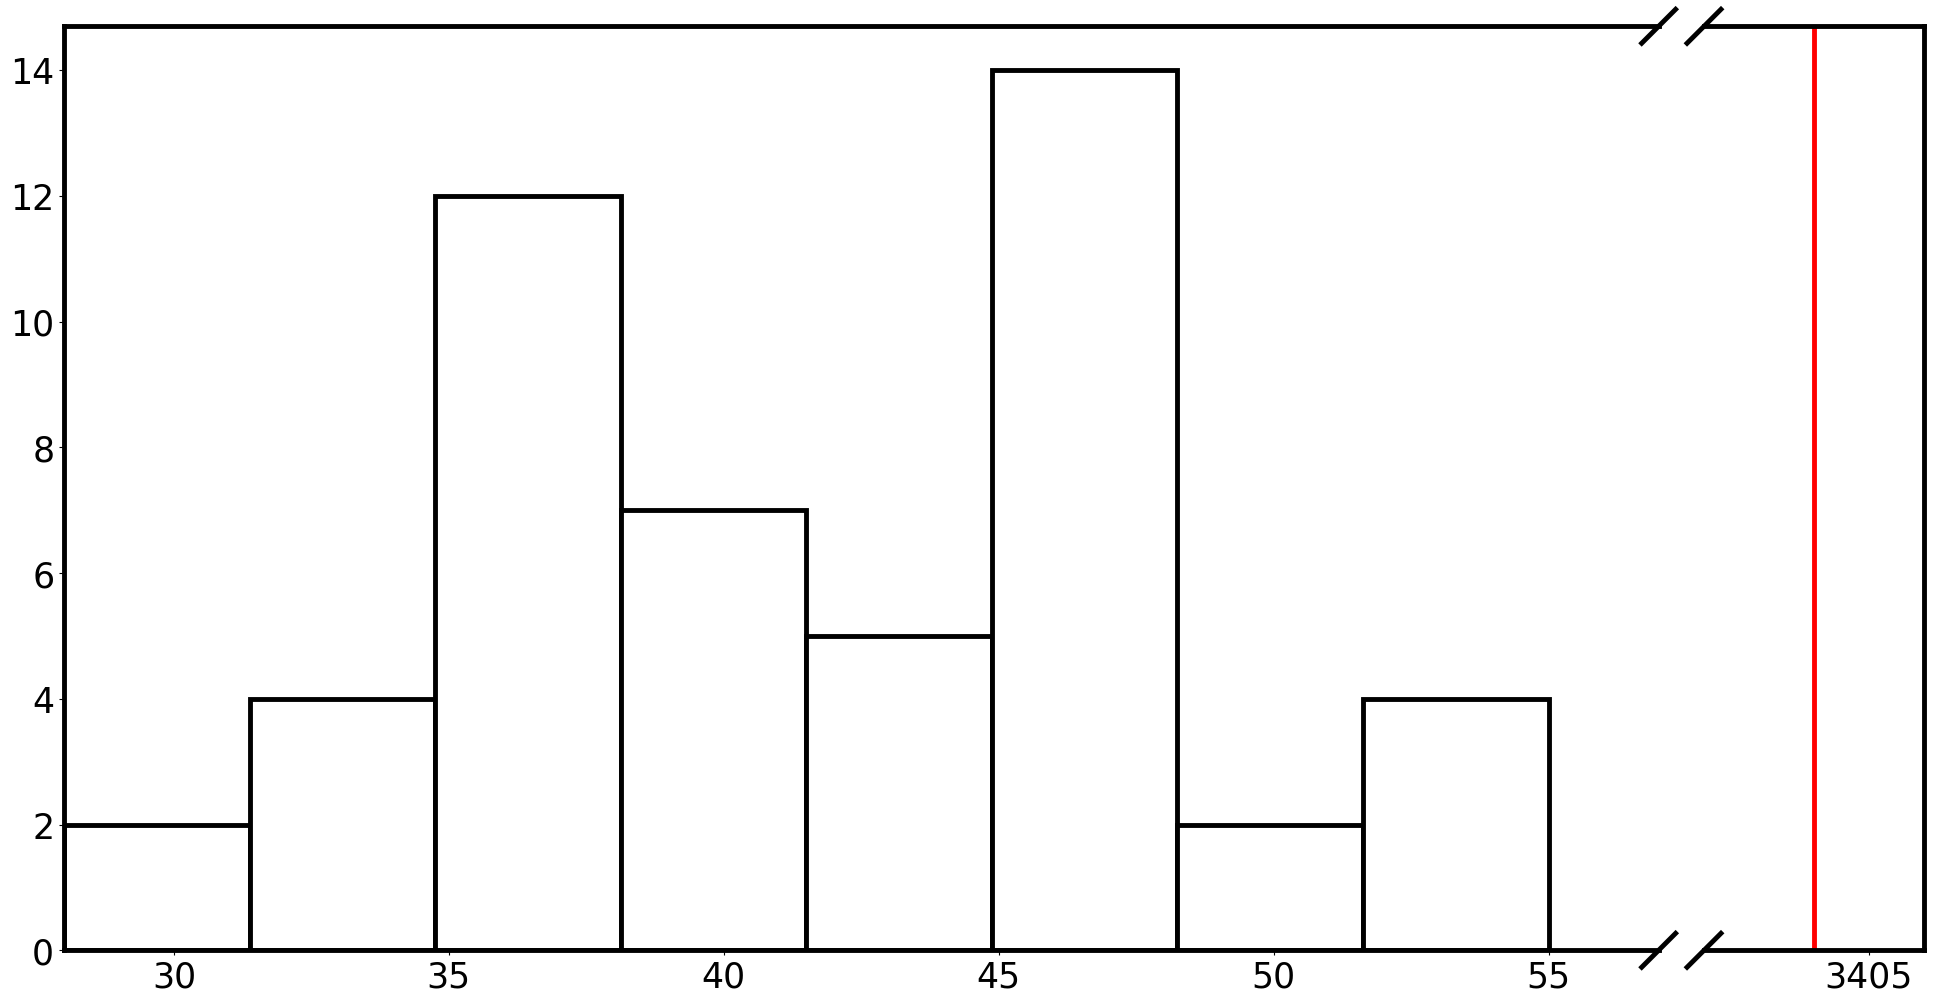

In [365]:
# depict random result picture: transposon similar
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from brokenaxes import brokenaxes

exp_result = 3404
control_min = min(random_transposon_similar_EPI_num_list)
control_max = max(random_transposon_similar_EPI_num_list)

fig = plt.figure(figsize=(24,12), linewidth=10)

ax = brokenaxes(xlims=((control_min, control_max+2), (exp_result-2, exp_result+2)),despine=False, wspace=0.05,d=0.01)

plt.rc('axes', linewidth=3.5)
plt.rcParams['font.size'] = 25  # 14pt font size  


ax.hist(random_transposon_similar_EPI_num_list, bins=8, edgecolor='black', color='white', linewidth=3.5)
ax.axvline(x=exp_result, color='red', linewidth=3.5)

plt.savefig("mouse_randomControl.svg", format="svg")

## eRNA analysis

In [366]:
# Get the sequence similar enhancer in EPI
blastResultFile = 'ErnaPI_blastResult.txt'
blastResultBedFile = 'ErnaPI_enhancerBlastHit.bed'
with open(blastResultFile, 'r') as infile, open(blastResultBedFile, 'w') as outfile:
	for line in infile:
		chromosome = line.split()[0].split(':')[0]
		startPre = int(line.split()[0].split(':')[1].split('-')[0])
		stopPre = int(line.split()[0].split(':')[1].split('-')[1].split('(')[0])
		name = line.split()[0]
		otherName = line.split()[1]
		strand = line.split()[0].split(':')[1].split('(')[1][0]
		if strand == '+' or strand == '.':
			if int(line.split()[6]) < int(line.split()[7]):
				shiftStart = int(line.split()[6])
				shiftEnd = int(line.split()[7])
			elif int(line.split()[6]) > int(line.split()[7]):
				shiftStart = int(line.split()[7])
				shiftEnd = int(line.split()[6])
			start = startPre + shiftStart - 1
			end = startPre + shiftEnd - 1
		elif strand == '-':
			if int(line.split()[6]) < int(line.split()[7]):
				shiftStart = int(line.split()[6])
				shiftEnd = int(line.split()[7])
			elif int(line.split()[6]) > int(line.split()[7]):
				shiftStart = int(line.split()[7])
				shiftEnd = int(line.split()[6])
			end = stopPre - shiftStart
			start = stopPre - shiftEnd
		print(f'{chromosome}\t{start}\t{end}\t{name}\t{otherName}\t{strand}', file=outfile)
        
# Get the sequence similar promoter in EPI
blastResultFile = 'ErnaPI_blastResult.txt'
blastResultBedFile = 'ErnaPI_promoterBlastHit.bed'
with open(blastResultFile, 'r') as infile, open(blastResultBedFile, 'w') as outfile:
	for line in infile:
		chromosome = line.split()[1].split(':')[0]
		startPre = int(line.split()[1].split(':')[1].split('-')[0])
		stopPre = int(line.split()[1].split(':')[1].split('-')[1].split('(')[0])
		name = line.split()[1]
		otherName = line.split()[0]
		strand = line.split()[1].split(':')[1].split('(')[1][0]
		if strand == '+' or strand == '.':
			if int(line.split()[8]) < int(line.split()[9]):
				shiftStart = int(line.split()[8])
				shiftEnd = int(line.split()[9])
			elif int(line.split()[8]) > int(line.split()[9]):
				shiftStart = int(line.split()[9])
				shiftEnd = int(line.split()[8])
			start = startPre + shiftStart - 1
			end = startPre + shiftEnd - 1
		elif strand == '-':
			if int(line.split()[8]) < int(line.split()[9]):
				shiftStart = int(line.split()[8])
				shiftEnd = int(line.split()[9])
			elif int(line.split()[8]) > int(line.split()[9]):
				shiftStart = int(line.split()[9])
				shiftEnd = int(line.split()[8])
			end = stopPre - shiftStart
			start = stopPre - shiftEnd
		print(f'{chromosome}\t{start}\t{end}\t{name}\t{otherName}\t{strand}', file=outfile)


In [372]:
# Get out the TE similar EPI, save as ep_same_{te}.bedpe
promoter_blast_df = pd.read_csv('ErnaPI_promoterBlastHit.bed', sep='\t', header=None)
enhancer_blast_df = pd.read_csv('ErnaPI_enhancerBlastHit.bed', sep='\t', header=None)
promoter_blast_df.columns = ['promoter_blastHit_chr', 'promoter_blastHit_start', 'promoter_blastHit_end', 'promoter', 'eRNA', 'promoter_strand']
enhancer_blast_df.columns = ['eRNA_blastHit_chr', 'eRNA_blastHit_start', 'eRNA_blastHit_end', 'eRNA', 'promoter', 'eRNA_strand']
epi_df = pd.read_csv('eRNAPI.bedpe', sep='\t', header=None)
epi_df.columns = ['eRNA_chr', 'eRNA_start', 'eRNA_end', 'promoter_chr', 'promoter_start', 'promoter_end',
               'epi_name', 'eRNA_score', 'eRNA_strand', 'promoter_strand']
promoter_blast_df['promoter_chr'] = promoter_blast_df['promoter'].str.split(':').str[0]
promoter_blast_df['promoter_start'] = promoter_blast_df['promoter'].str.split(':').str[1].str.split('-').str[0].str.split('(').str[0].astype(int)
promoter_blast_df['promoter_end'] = promoter_blast_df['promoter'].str.split(':').str[1].str.split('-').str[1].str.split('(').str[0].astype(int)
promoter_blast_df['eRNA_chr'] = promoter_blast_df['eRNA'].str.split(':').str[0]
promoter_blast_df['eRNA_start'] = promoter_blast_df['eRNA'].str.split(':').str[1].str.split('-').str[0].str.split('(').str[0].astype(int)
promoter_blast_df['eRNA_end'] = promoter_blast_df['eRNA'].str.split(':').str[1].str.split('-').str[1].str.split('(').str[0].astype(int)

enhancer_blast_df['eRNA_chr'] = enhancer_blast_df['eRNA'].str.split(':').str[0]
enhancer_blast_df['eRNA_start'] = enhancer_blast_df['eRNA'].str.split(':').str[1].str.split('-').str[0].str.split('(').str[0].astype(int)
enhancer_blast_df['eRNA_end'] = enhancer_blast_df['eRNA'].str.split(':').str[1].str.split('-').str[1].str.split('(').str[0].astype(int)
enhancer_blast_df['promoter_chr'] = enhancer_blast_df['promoter'].str.split(':').str[0]
enhancer_blast_df['promoter_start'] = enhancer_blast_df['promoter'].str.split(':').str[1].str.split('-').str[0].str.split('(').str[0].astype(int)
enhancer_blast_df['promoter_end'] = enhancer_blast_df['promoter'].str.split(':').str[1].str.split('-').str[1].str.split('(').str[0].astype(int)

# # Get out the intersection between transposon and blastHit
# transposonFile = 'mm10.fa.bed'
# x = pd.merge(epi_df, promoter_blast_df, on=['eRNA_chr', 'eRNA_start', 'eRNA_end', 'promoter_chr', 
#                                             'promoter_start', 'promoter_end', 'promoter_strand'], how='inner')
# y = pd.merge(x, enhancer_blast_df, on=['eRNA_chr', 'eRNA_start', 'eRNA_end', 'promoter_chr', 
#                                        'promoter_start', 'promoter_end', 'promoter', 'eRNA', 'eRNA_strand'
#                                        ], how='inner')
# cmd = f"bedtools intersect -a ErnaPI_promoterBlastHit.bed -b {transposonFile} -wo -f 0.8 -F 0.8 -e > ErnaPI_promoterBlastHit_transposon_intersectWo.bed"
# subprocess.run(cmd, shell=True)
# cmd = f"bedtools intersect -a ErnaPI_enhancerBlastHit.bed -b {transposonFile} -wo -f 0.8 -F 0.8 -e > ErnaPI_enhancerBlastHit_transposon_intersectWo.bed"
# subprocess.run(cmd, shell=True)

promoter_blast_te_intersectWo_df = pd.read_csv('ErnaPI_promoterBlastHit_transposon_intersectWo.bed', sep='\t', header=None)
enhancer_blast_te_intersectWo_df = pd.read_csv('ErnaPI_enhancerBlastHit_transposon_intersectWo.bed', sep='\t', header=None)
promoter_blast_te_intersectWo_df = promoter_blast_te_intersectWo_df.rename({
    0:'promoter_blastHit_chr', 1:'promoter_blastHit_start', 2:'promoter_blastHit_end', 
    3:'promoter', 4:'eRNA', 5:'promoter_strand'}, axis=1)
enhancer_blast_te_intersectWo_df = enhancer_blast_te_intersectWo_df.rename({
    0:'eRNA_blastHit_chr', 1:'eRNA_blastHit_start', 2:'eRNA_blastHit_end',
    3:'eRNA', 4:'promoter', 5:'eRNA_strand'}, axis=1)

# merge the promoter and enhancer information together
transposon_similar_EPI_df = pd.merge(
    pd.merge(y, promoter_blast_te_intersectWo_df, on=['promoter_blastHit_chr', 'promoter_blastHit_start', 'promoter_blastHit_end',
                                                  'promoter', 'eRNA', 'promoter_strand'], how='inner'),
    enhancer_blast_te_intersectWo_df, on=['eRNA_blastHit_chr', 'eRNA_blastHit_start', 'eRNA_blastHit_end',
                                            'eRNA', 'promoter', 'eRNA_strand'], how='inner')

transposon_similar_EPI_df = transposon_similar_EPI_df[transposon_similar_EPI_df['12_x'] == transposon_similar_EPI_df['12_y']]
SINE_similar_EPI_df = transposon_similar_EPI_df[transposon_similar_EPI_df['12_x'].str.contains('SINE')]

In [369]:
# seuquence-similar EPI num
print(y['epi_name'].drop_duplicates().shape[0])

# transposon-similar EPI num
print(transposon_similar_EPI_df['epi_name'].drop_duplicates().shape[0])

# SINE-similar EPI num
print(SINE_similar_EPI_df['epi_name'].drop_duplicates().shape[0])

# each transposon ratio in transposon-similar EPI (corrected by copy number)
df = pd.read_csv(transposonFile, sep='\t', header=None)
transposon_num_dict = transposon_similar_EPI_df['12_x'].value_counts()
transposon_copyNum_dict = df[6].value_counts().to_dict()
transposon_num_correct_dict = dict()
for key in transposon_num_dict.keys():
    result = transposon_num_dict[key] / transposon_copyNum_dict[key]
    transposon_num_correct_dict[key] = [result]
for key, value in (pd.DataFrame.from_dict(transposon_num_correct_dict).T / pd.DataFrame.from_dict(transposon_num_correct_dict).T.sum())[0].to_dict().items():
    print(key, round(value, 2))

# result save
for i, j in SINE_similar_EPI_df.groupby('12_x'):
    j[['eRNA_chr', 'eRNA_start', 'eRNA_end', 'promoter_chr', 'promoter_start', 'promoter_end', 'epi_name', 'eRNA_score', 'eRNA_strand', 'promoter_strand']
 ].drop_duplicates('epi_name').to_csv(f"eRNAp_same_{i.replace('/', '_')}.bedpe", sep='\t', header=None, index=None)

497
449
439
SINE/Alu 0.82
SINE/B2 0.16
Simple_repeat 0.0
LTR/ERVL-MaLR 0.01
SINE/B4 0.0
DNA/hAT-Charlie 0.01


# Calculate the relation between SINE polyA length and corrected ratio

In [371]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd
import scipy

In [373]:
a = SINE_similar_EPI_df['9_x'].value_counts()
b = SINE_similar_EPI_df['9_y'].value_counts()

In [375]:
sine_num = pd.DataFrame([a, b]).fillna(0).sum(axis=0)
df = pd.read_csv('mm10.SINE.withpPolyaLength_newMethod2.bed', sep='\t', header=None)
polyA_length = df.groupby(3).agg({14:'mean'})
polyA_length.columns = ['Sine polyA length'] 
polyA_length_std = df.groupby(3).agg({14:'std'})
sine_copy_num = df[3].value_counts()
te_familty_dict = dict(zip(df[3], df[6].str.split('/').str[1]))
polyA_length['sine_copy_num'] = sine_copy_num
polyA_length['sine_num'] = sine_num
polyA_length = polyA_length.fillna(0)
polyA_length['correct_num'] = polyA_length['sine_num']/polyA_length['sine_copy_num']
polyA_length['Correct Ratio'] = polyA_length['correct_num'] / polyA_length['correct_num'].sum()
polyA_length['sine_length_std'] = polyA_length_std
polyA_length['kind'] = polyA_length.index.map(te_familty_dict)

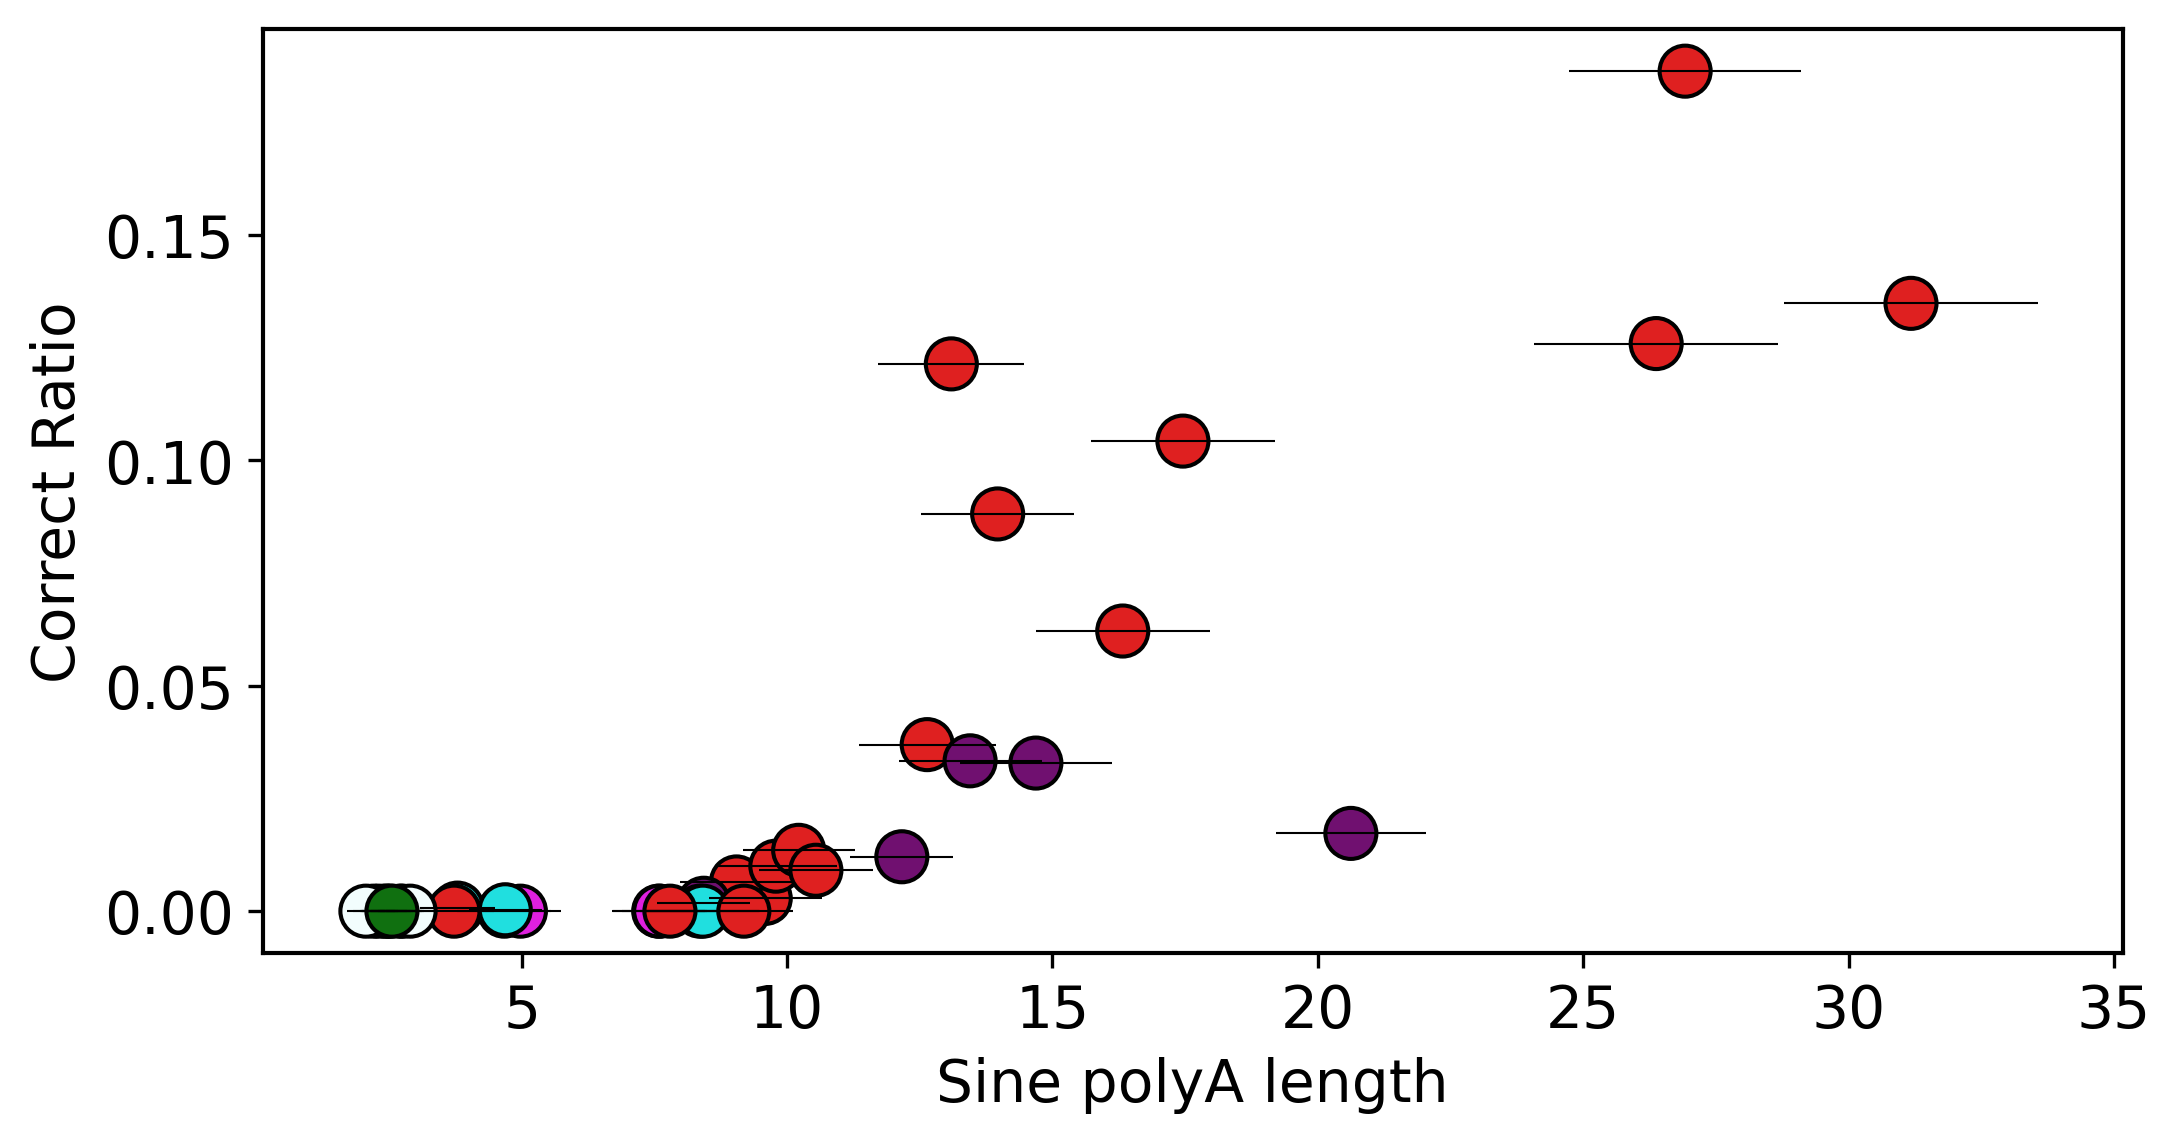

In [383]:
plt.figure(dpi=300,figsize=(8,4))
plt.rc('axes', linewidth=1)
plt.rcParams['font.size'] = 14  # 14pt font size  
ax = sns.scatterplot(data=polyA_length, y='Correct Ratio', x='Sine polyA length', hue='kind', 
                     palette={'Alu':'#df2020', 'B2': '#701070', 'B4':'#20dfdf', 'ID':'#df20df', 'MIR':'#f2fdfd', 
                              'tRNA-Deu':'#df9c20', 'tRNA-RTE':'#107010', 'tRNA':'#f7c8d0', '5S-Deu-L2':'#808080'},
                     edgecolor='black',
                     marker='o',
                     s=150,
                     legend=False)
plt.errorbar(x=polyA_length['Sine polyA length'], y=polyA_length['Correct Ratio'], xerr=polyA_length['sine_length_std']*0.1, fmt='none', c='black', 
             elinewidth=0.5, capsize=0)
plt.savefig('CorrectRatio.svg', format='svg', dpi=300)